<h1>기본 가정</h1>
<div>따릉이는 대중교통 대체 수단으로 많이 이용될 것이기 때문에 시간 변수에 가장 큰 영향을 받을 것이다. 예를 들어 출근 시간대 (오전 7시~9시)와 퇴근 시간대 (오후 5시~7시) 의 따릉이 대여량이 가장 높을 것으로 예상되고 0시 이후부터 출근 전 까지인 심야 및 새벽 시간대에는 따릉이 대여량이 저조할 것이다.</div>

In [1]:
# 라이브러리 import, 데이터 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/submission.csv')
model = DecisionTreeRegressor()

<h1>EDA(탐색적 데이터 분석)</h1>

In [2]:
# 데이터 확인하기
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [3]:
# 변수 당 결측치 확인
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [4]:
# 데이터 타입, 개수, 결측치 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


<h2>결측치가 존재하는 테이블</h2>
<li>temperature</li>
<li>precipitation</li>
<li>windspeed</li>
<li>humidity</li>
<li>visibility</li>
<li>ozone</li>
<li>pm10</li>
<li>pm2.5</li>

<AxesSubplot:xlabel='hour'>

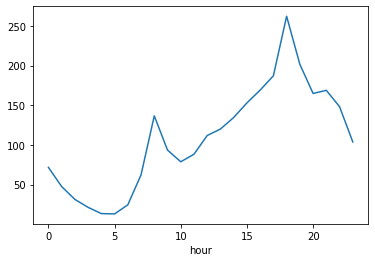

In [5]:
# x 변수를 시간으로, y 변수를 따릉이 대여량으로 선언 후 시각화
train.groupby('hour').mean()['count'].plot()

<div>위에서 가정했듯이 출퇴근 시간대에 대여량이 높고 심야 및 새벽 시간대에는 대여량이 낮다</div>

<AxesSubplot:>

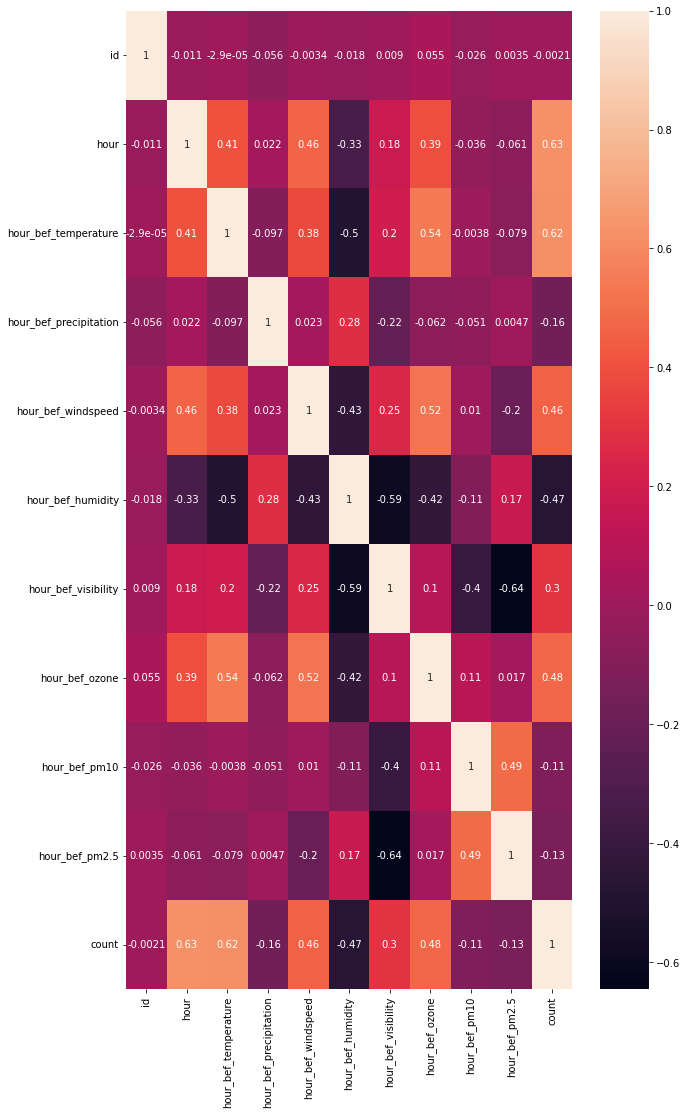

In [6]:
# heatmap으로 각 변수 간 상관관계 분석 시각화
plt.figure(figsize=(10,18))
sns.heatmap(train.corr(),annot=True)

<div>고유 id는 어떠한 변수와도 유의미한 상관관계를 가지지 않으므로 제외한다</div>

<h1>데이터 전처리</h1>

In [7]:
# features 및 target 지정
features = [
            #'id',
            'hour',
            'hour_bef_temperature',
            #'hour_bef_precipitation',
            'hour_bef_windspeed',
            'hour_bef_humidity',
            'hour_bef_visibility',
            'hour_bef_ozone',
            #'hour_bef_pm10',
            #'hour_bef_pm2.5'
           ]
target = 'count'

train = train[features + [target]]
test = test[features]

In [ ]:
# knn을 이용해 결측치 보간
import sys
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(1000000)

train_impyute = fast_knn(train.values,k=30) # set neighbor data = 30
test_impyute = fast_knn(test.values,k=30)

train = pd.DataFrame(train_impyute,columns=train.columns)
test = pd.DataFrame(test_impyute,columns=test.columns)

In [ ]:
# target 지정
X_train = train[features]
Y_train = train[target]

<h1>데이터 학습(ML)</h1>

In [ ]:
# Dicision Tree 방식
model = DecisionTreeRegressor()
model.fit(X_train,Y_train)
accuracies = cross_val_score(model,X_train,Y_train,cv=5)
print(accuracies)
print("accuracy(mean)=%0.3f, 표준편차=%0.3f"%(accuracies.mean()*100,accuracies.std()))
pred = model.predict(test)
pred[:5]

[0.52073357 0.5417675  0.58157214 0.59035675 0.58763378]
accuracy(mean)=56.441, 표준편차=0.028


array([ 26., 215.,  82.,  18., 134.])

In [ ]:
# 랜덤 포레스트 방식
model = RandomForestRegressor(n_estimators=200)
model.fit(X_train,Y_train)
accuracies = cross_val_score(model,X_train,Y_train,cv=5)
print(accuracies)
print("accuracy(mean)=%0.3f, 표준편차=%0.3f"%(accuracies.mean()*100,accuracies.std()))
pred = model.predict(test)
pred[:5]

[0.76436085 0.75207681 0.80507885 0.74621468 0.77563078]
accuracy(mean)=76.867, 표준편차=0.021


array([ 94.64 , 227.76 ,  95.47 ,  28.915,  68.66 ])

In [ ]:
#제출 파일 생성
submission['count'] = pred
submission.to_csv('sub.csv',index=False)